In [4]:
#!cp ~/dl_prob/sample_extract/keras_models/*notop* ~/.keras/models/

In [5]:
#!cp ~/dl_prob/sample_extract/keras_models/imagenet_class_index.json ~/.keras/models/

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import gzip
import json

import PIL

import numpy as np
import pandas as pd
import skimage
pd.set_option('max_columns', 50)
pd.set_option('max_rows', 1000)

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8, 6)

from pandas.io.parsers import read_csv
from sklearn.utils import shuffle

from IPython.core.display import display, HTML, Image

In [2]:
def img_to_array(img):
    return np.array(img.getdata()).reshape(img.width, img.width, 3) / 255


def trim(im):
    """trim black margin, http://stackoverflow.com/questions/10615901/trim-whitespace-using-pil"""
    bg = PIL.Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = PIL.ImageChops.difference(im, bg)
    diff = PIL.ImageChops.add(diff, diff, 2.0, -20)
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox)


def calc_thumbnail_size(img):
    """calculate thumbnail size with constant aspect ratio"""
    width, length = img.size
    ratio = width / length

    # for some reason, if it's exactly 224, then thumnailed image is 223
    dim = 224 + 1          # output dim
    if ratio > 1:
        size = (dim * ratio, dim)
    else:
        size = (dim, dim / ratio)
#     print(size)
    return size


def calc_crop_coords(img):
    """crop to square of desired dimension size"""
    dim = 224
    width, length = img.size
    left = 0
    right = width
    bottom = length
    top = 0
    if width > dim:
        delta = (width - dim) / 2
        left = delta
        right = width - delta
    if length > dim:
        delta = (length - dim) / 2
        top = delta
        bottom = length - delta
    return (left, top, right, bottom)


def preprocess(img):
    img = trim(img)
    tsize = calc_thumbnail_size(img)
    img.thumbnail(tsize)
    crop_coords = calc_crop_coords(img)
    img = img.crop(crop_coords)
    return img


In [3]:
df = pd.read_csv('train/trainLabels.csv')

In [4]:
df.level.value_counts().to_frame(name='count')

,count
0,25810
2,5292
1,2443
3,873
4,708


In [5]:
df = df.query('image in {0}'.format([_.replace('.jpeg', '') for _ in os.listdir('train')]))

In [6]:
data_dir = 'train'

In [7]:
PIL.__version__

'5.3.0'

In [ ]:
imgs_with_label = []
n_samples = 5
for i in range(5):
    _vals = df.query('level == {0}'.format(i)).sample(n_samples).image.apply(
        lambda v: (os.path.join(data_dir, v) + '.jpeg', i)).values.tolist()
    imgs_with_label.extend(_vals)

fig, axes = plt.subplots(5, 5, figsize=(16, 16))
axes = axes.ravel()
for k, (img, label) in enumerate(imgs_with_label):
    im = PIL.Image.open(img)
    im = preprocess(im)
    ax = axes[k]
    ax.imshow(img_to_array(im))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(False)
    if k % 5 == 0:
        ax.set_ylabel('level = {0}'.format(label))
    ax.set_title(os.path.basename(img))

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # showing and rendering figures
# io related
from skimage.io import imread
import os
from glob import glob
# not needed in Kaggle, but required in Jupyter
%matplotlib inline 

In [2]:
base_image_dir = os.path.join('train')
retina_df = pd.read_csv(os.path.join(base_image_dir, 'trainLabels.csv'))
retina_df['PatientId'] = retina_df['image'].map(lambda x: x.split('_')[0])
retina_df['path'] = retina_df['image'].map(lambda x: os.path.join(base_image_dir,
                                                         '{}.jpeg'.format(x)))
retina_df['exists'] = retina_df['path'].map(os.path.exists)
print(retina_df['exists'].sum(), 'images found of', retina_df.shape[0], 'total')
retina_df['eye'] = retina_df['image'].map(lambda x: 1 if x.split('_')[-1]=='left' else 0)
from keras.utils.np_utils import to_categorical
retina_df['level_cat'] = retina_df['level'].map(lambda x: to_categorical(x, 1+retina_df['level'].max()))

retina_df.dropna(inplace = True)
retina_df = retina_df[retina_df['exists']]
retina_df.sample(3)

35126 images found of 35126 total


Using TensorFlow backend.


,image,level,PatientId,path,exists,eye,level_cat
20785,26204_right,0,26204,train/26204_right.jpeg,True,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
18446,23244_left,3,23244,train/23244_left.jpeg,True,1,"[0.0, 0.0, 0.0, 1.0, 0.0]"
28289,35813_right,0,35813,train/35813_right.jpeg,True,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0dcd057860>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f0dcd037630>]], dtype=object)

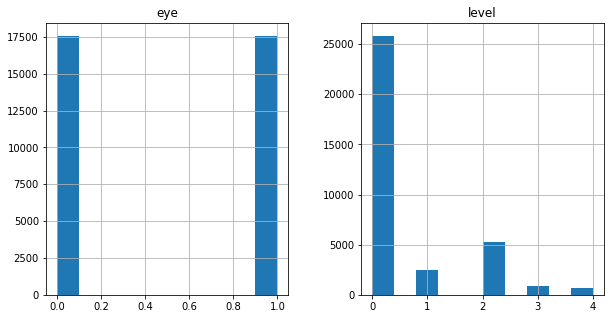

In [3]:
retina_df[['level', 'eye']].hist(figsize = (10, 5))

In [4]:
from sklearn.model_selection import train_test_split
rr_df = retina_df[['PatientId', 'level']].drop_duplicates()
train_ids, valid_ids = train_test_split(rr_df['PatientId'], 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = rr_df['level'])
raw_train_df = retina_df[retina_df['PatientId'].isin(train_ids)]
valid_df = retina_df[retina_df['PatientId'].isin(valid_ids)]
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0])

train 27176 validation 9632


New Data Size: 750 Old Size: 27176


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0dcb29e3c8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f0dcb24aeb8>]], dtype=object)

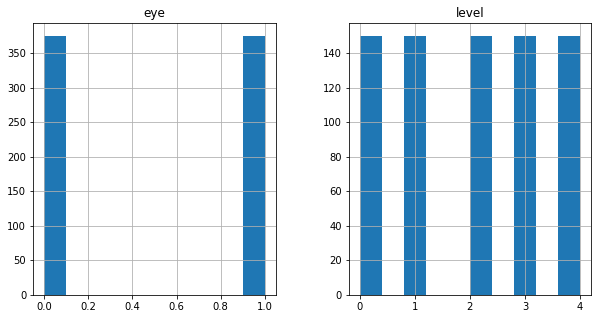

In [5]:
train_df = raw_train_df.groupby(['level', 'eye']).apply(lambda x: x.sample(75, replace = True)
                                                      ).reset_index(drop = True)
#train_df = raw_train_df    
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])
train_df[['level', 'eye']].hist(figsize = (10, 5))

In [6]:
import tensorflow as tf
from keras import backend as K
from keras.applications.inception_v3 import preprocess_input
import numpy as np
IMG_SIZE = (512, 512) # slightly smaller than vgg16 normally expects
def tf_image_loader(out_size, 
                      horizontal_flip = True, 
                      vertical_flip = False, 
                     random_brightness = True,
                     random_contrast = True,
                    random_saturation = True,
                    random_hue = True,
                      color_mode = 'rgb',
                       preproc_func = preprocess_input,
                       on_batch = False):
    def _func(X):
        with tf.name_scope('image_augmentation'):
            with tf.name_scope('input'):
                X = tf.image.decode_png(tf.read_file(X), channels = 3 if color_mode == 'rgb' else 0)
                X = tf.image.resize_images(X, out_size)
            with tf.name_scope('augmentation'):
                if horizontal_flip:
                    X = tf.image.random_flip_left_right(X)
                if vertical_flip:
                    X = tf.image.random_flip_up_down(X)
                if random_brightness:
                    X = tf.image.random_brightness(X, max_delta = 0.1)
                if random_saturation:
                    X = tf.image.random_saturation(X, lower = 0.75, upper = 1.5)
                if random_hue:
                    X = tf.image.random_hue(X, max_delta = 0.15)
                if random_contrast:
                    X = tf.image.random_contrast(X, lower = 0.75, upper = 1.5)
                return preproc_func(X)
    if on_batch: 
        # we are meant to use it on a batch
        def _batch_func(X, y):
            return tf.map_fn(_func, X), y
        return _batch_func
    else:
        # we apply it to everything
        def _all_func(X, y):
            return _func(X), y         
        return _all_func
    
def tf_augmentor(out_size,
                intermediate_size = (640, 640),
                 intermediate_trans = 'crop',
                 batch_size = 16,
                   horizontal_flip = True, 
                  vertical_flip = False, 
                 random_brightness = True,
                 random_contrast = True,
                 random_saturation = True,
                    random_hue = True,
                  color_mode = 'rgb',
                   preproc_func = preprocess_input,
                   min_crop_percent = 0.001,
                   max_crop_percent = 0.005,
                   crop_probability = 0.5,
                   rotation_range = 10):
    
    load_ops = tf_image_loader(out_size = intermediate_size, 
                               horizontal_flip=horizontal_flip, 
                               vertical_flip=vertical_flip, 
                               random_brightness = random_brightness,
                               random_contrast = random_contrast,
                               random_saturation = random_saturation,
                               random_hue = random_hue,
                               color_mode = color_mode,
                               preproc_func = preproc_func,
                               on_batch=False)
    def batch_ops(X, y):
        batch_size = tf.shape(X)[0]
        with tf.name_scope('transformation'):
            # code borrowed from https://becominghuman.ai/data-augmentation-on-gpu-in-tensorflow-13d14ecf2b19
            # The list of affine transformations that our image will go under.
            # Every element is Nx8 tensor, where N is a batch size.
            transforms = []
            identity = tf.constant([1, 0, 0, 0, 1, 0, 0, 0], dtype=tf.float32)
            if rotation_range > 0:
                angle_rad = rotation_range / 180 * np.pi
                angles = tf.random_uniform([batch_size], -angle_rad, angle_rad)
                transforms += [tf.contrib.image.angles_to_projective_transforms(angles, intermediate_size[0], intermediate_size[1])]

            if crop_probability > 0:
                crop_pct = tf.random_uniform([batch_size], min_crop_percent, max_crop_percent)
                left = tf.random_uniform([batch_size], 0, intermediate_size[0] * (1.0 - crop_pct))
                top = tf.random_uniform([batch_size], 0, intermediate_size[1] * (1.0 - crop_pct))
                crop_transform = tf.stack([
                      crop_pct,
                      tf.zeros([batch_size]), top,
                      tf.zeros([batch_size]), crop_pct, left,
                      tf.zeros([batch_size]),
                      tf.zeros([batch_size])
                  ], 1)
                coin = tf.less(tf.random_uniform([batch_size], 0, 1.0), crop_probability)
                transforms += [tf.where(coin, crop_transform, tf.tile(tf.expand_dims(identity, 0), [batch_size, 1]))]
            if len(transforms)>0:
                X = tf.contrib.image.transform(X,
                      tf.contrib.image.compose_transforms(*transforms),
                      interpolation='BILINEAR') # or 'NEAREST'
            if intermediate_trans=='scale':
                X = tf.image.resize_images(X, out_size)
            elif intermediate_trans=='crop':
                X = tf.image.resize_image_with_crop_or_pad(X, out_size[0], out_size[1])
            else:
                raise ValueError('Invalid Operation {}'.format(intermediate_trans))
            return X, y
    def _create_pipeline(in_ds):
        batch_ds = in_ds.map(load_ops, num_parallel_calls=4).batch(batch_size)
        return batch_ds.map(batch_ops)
    return _create_pipeline

In [7]:
def flow_from_dataframe(idg, 
                        in_df, 
                        path_col,
                        y_col, 
                        shuffle = True, 
                        color_mode = 'rgb'):
    files_ds = tf.data.Dataset.from_tensor_slices((in_df[path_col].values, 
                                                   np.stack(in_df[y_col].values,0)))
    in_len = in_df[path_col].values.shape[0]
    while True:
        if shuffle:
            files_ds = files_ds.shuffle(in_len) # shuffle the whole dataset
        
        next_batch = idg(files_ds).repeat().make_one_shot_iterator().get_next()
        for i in range(max(in_len//32,1)):
            # NOTE: if we loop here it is 'thread-safe-ish' if we loop on the outside it is completely unsafe
            yield K.get_session().run(next_batch)


In [8]:
batch_size = 48
core_idg = tf_augmentor(out_size = IMG_SIZE, 
                        color_mode = 'rgb', 
                        vertical_flip = True,
                        crop_probability=0.0, # crop doesn't work yet
                        batch_size = batch_size) 
valid_idg = tf_augmentor(out_size = IMG_SIZE, color_mode = 'rgb', 
                         crop_probability=0.0, 
                         horizontal_flip = False, 
                         vertical_flip = False, 
                         random_brightness = False,
                         random_contrast = False,
                         random_saturation = False,
                         random_hue = False,
                         rotation_range = 0,
                        batch_size = batch_size)

train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'path',
                            y_col = 'level_cat')

valid_gen = flow_from_dataframe(valid_idg, valid_df, 
                             path_col = 'path',
                            y_col = 'level_cat') # we can use much larger batches for evaluation

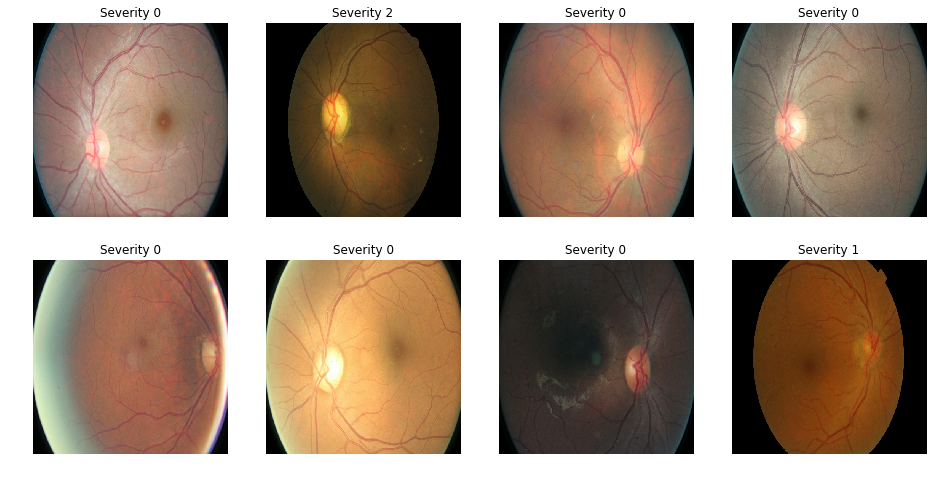

In [9]:


t_x, t_y = next(valid_gen)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(np.clip(c_x*127+127, 0, 255).astype(np.uint8))
    c_ax.set_title('Severity {}'.format(np.argmax(c_y, -1)))
    c_ax.axis('off')



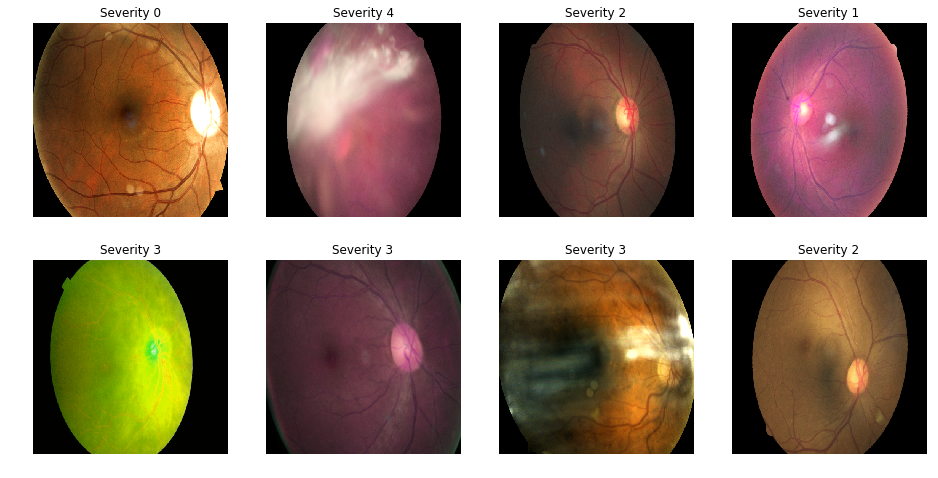

In [10]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(np.clip(c_x*127+127, 0, 255).astype(np.uint8))
    c_ax.set_title('Severity {}'.format(np.argmax(c_y, -1)))
    c_ax.axis('off')

In [11]:
from keras.applications.vgg16 import VGG16 as PTModel
from keras.applications.inception_resnet_v2 import InceptionResNetV2 as PTModel
from keras.applications.inception_v3 import InceptionV3 as PTModel
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model
in_lay = Input(t_x.shape[1:])
base_pretrained_model = PTModel(input_shape =  t_x.shape[1:], include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False
pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
pt_features = base_pretrained_model(in_lay)
from keras.layers import BatchNormalization
bn_features = BatchNormalization()(pt_features)

# here we do an attention mechanism to turn pixels in the GAP on an off

attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(Dropout(0.5)(bn_features))
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(8, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(1, 
                    kernel_size = (1,1), 
                    padding = 'valid', 
                    activation = 'sigmoid')(attn_layer)
# fan it out to all of the channels
up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', 
               activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)

mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)
# to account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.25)(gap)
dr_steps = Dropout(0.25)(Dense(128, activation = 'relu')(gap_dr))
out_layer = Dense(t_y.shape[-1], activation = 'softmax')(dr_steps)
retina_model = Model(inputs = [in_lay], outputs = [out_layer])
from keras.metrics import top_k_categorical_accuracy
def top_2_accuracy(in_gt, in_pred):
    return top_k_categorical_accuracy(in_gt, in_pred, k=2)

retina_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy', top_2_accuracy])
retina_model.summary()


87916544/87910968 [==============================] - 8s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 14, 14, 2048) 21802784    input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 14, 14, 2048) 8192        inception_v3[1][0]               
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 14, 14, 2048) 0           batch_normalization_95[0][0]     
____________________________________________

In [12]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('retina')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=6) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/keras/callbacks.py:928: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` insted.
  warnings.warn('`epsilon` argument is deprecated and '


In [13]:
!rm -rf ~/.keras # clean up before starting training

In [14]:
retina_model.fit_generator(train_gen, 
                           steps_per_epoch = train_df.shape[0]//batch_size,
                           validation_data = valid_gen, 
                           validation_steps = valid_df.shape[0]//batch_size,
                              epochs = 25, 
                              callbacks = callbacks_list,
                             workers = 0, # tf-generators are not thread-safe
                             use_multiprocessing=False, 
                             max_queue_size = 0
                            )

Epoch 1/25
15/15 [==============================] - 467s 31s/step - loss: 1.6117 - categorical_accuracy: 0.2373 - top_2_accuracy: 0.4711 - val_loss: 1.4803 - val_categorical_accuracy: 0.1768 - val_top_2_accuracy: 0.6240

Epoch 00001: val_loss improved from inf to 1.48028, saving model to retina_weights.best.hdf5
Epoch 2/25
15/15 [==============================] - 426s 28s/step - loss: 1.4646 - categorical_accuracy: 0.3722 - top_2_accuracy: 0.6167 - val_loss: 1.7636 - val_categorical_accuracy: 0.1051 - val_top_2_accuracy: 0.4684

Epoch 00002: val_loss did not improve from 1.48028
Epoch 3/25
15/15 [==============================] - 421s 28s/step - loss: 1.4032 - categorical_accuracy: 0.4126 - top_2_accuracy: 0.6309 - val_loss: 1.7719 - val_categorical_accuracy: 0.0915 - val_top_2_accuracy: 0.7503

Epoch 00003: val_loss did not improve from 1.48028
Epoch 4/25
15/15 [==============================] - 429s 29s/step - loss: 1.3877 - categorical_accuracy: 0.3792 - top_2_accuracy: 0.6500 - val

In [15]:
retina_model.load_weights(weight_path)
retina_model.save('full_retina_model.h5')

In [19]:
##### create one fixed dataset for evaluating
from tqdm import tqdm_notebook
# fresh valid gen
valid_gen = flow_from_dataframe(valid_idg, valid_df, 
                             path_col = 'path',
                            y_col = 'level_cat') 
vbatch_count = (250//batch_size-1)
out_size = vbatch_count*batch_size
test_X = np.zeros((out_size,)+t_x.shape[1:], dtype = np.float32)
test_Y = np.zeros((out_size,)+t_y.shape[1:], dtype = np.float32)
for i, (c_x, c_y) in zip(tqdm_notebook(range(vbatch_count)), 
                         valid_gen):
    j = i*batch_size
    test_X[j:(j+c_x.shape[0])] = c_x
    test_Y[j:(j+c_x.shape[0])] = c_y

HBox(children=(IntProgress(value=0, max=4), HTML(value='')))

In [20]:
for attn_layer in retina_model.layers:
    c_shape = attn_layer.get_output_shape_at(0)
    if len(c_shape)==4:
        if c_shape[-1]==1:
            print(attn_layer)
            break

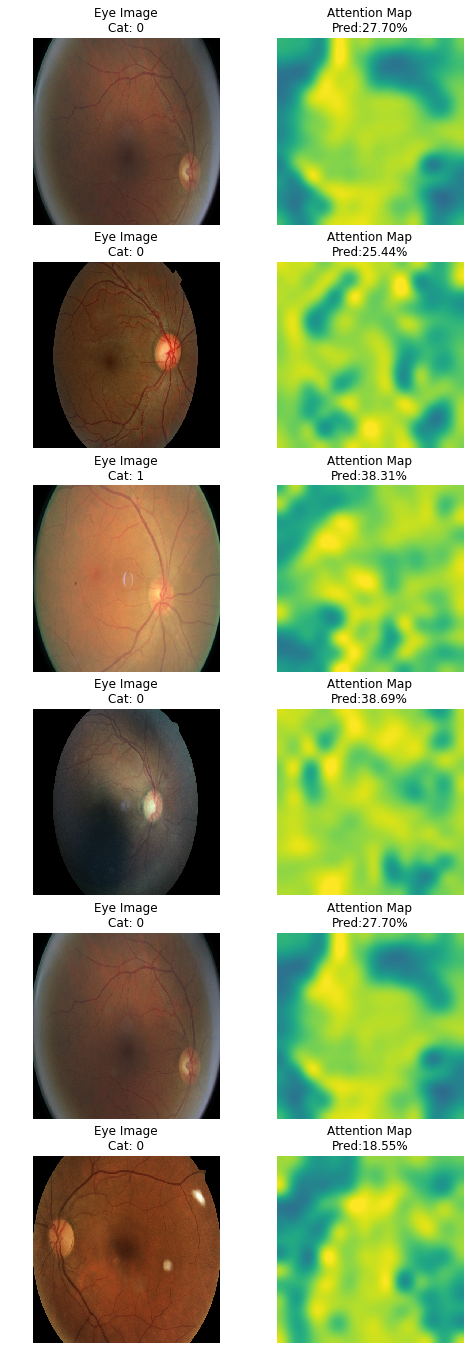

In [21]:
import keras.backend as K
rand_idx = np.random.choice(range(len(test_X)), size = 6)
attn_func = K.function(inputs = [retina_model.get_input_at(0), K.learning_phase()],
           outputs = [attn_layer.get_output_at(0)]
          )
fig, m_axs = plt.subplots(len(rand_idx), 2, figsize = (8, 4*len(rand_idx)))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for c_idx, (img_ax, attn_ax) in zip(rand_idx, m_axs):
    cur_img = test_X[c_idx:(c_idx+1)]
    attn_img = attn_func([cur_img, 0])[0]
    img_ax.imshow(np.clip(cur_img[0,:,:,:]*127+127, 0, 255).astype(np.uint8))
    attn_ax.imshow(attn_img[0, :, :, 0]/attn_img[0, :, :, 0].max(), cmap = 'viridis', 
                   vmin = 0, vmax = 1, 
                   interpolation = 'lanczos')
    real_cat = np.argmax(test_Y[c_idx, :])
    img_ax.set_title('Eye Image\nCat:%2d' % (real_cat))
    pred_cat = retina_model.predict(cur_img)
    attn_ax.set_title('Attention Map\nPred:%2.2f%%' % (100*pred_cat[0,real_cat]))
fig.savefig('attention_map.png', dpi = 300)

In [22]:
from sklearn.metrics import accuracy_score, classification_report
pred_Y = retina_model.predict(test_X, batch_size = 32, verbose = True)
pred_Y_cat = np.argmax(pred_Y, -1)
test_Y_cat = np.argmax(test_Y, -1)
print('Accuracy on Test Data: %2.2f%%' % (accuracy_score(test_Y_cat, pred_Y_cat)))
print(classification_report(test_Y_cat, pred_Y_cat))

192/192 [==============================] - 4s 22ms/step
Accuracy on Test Data: 0.39%
             precision    recall  f1-score   support

          0       0.74      0.41      0.53       136
          1       0.16      0.75      0.26        20
          2       0.25      0.10      0.15        29
          3       0.00      0.00      0.00         4
          4       0.10      0.33      0.15         3

avg / total       0.58      0.39      0.43       192



/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


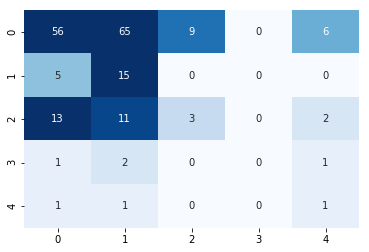

In [23]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(test_Y_cat, pred_Y_cat), 
            annot=True, fmt="d", cbar = False, cmap = plt.cm.Blues, vmax = test_X.shape[0]//16)